In [1]:
import rarfile 
import os 
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as pl
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
import numpy as np
from tensorflow.keras.optimizers import Adam

In [2]:
#train_path
train_dataset_path = r"D:\ML\Dogs vs Cats\dataset\train"


In [3]:
print(train_dataset_path)
print(os.listdir(train_dataset_path))


D:\ML\Dogs vs Cats\dataset\train
['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg', 'cat.10000.jpg', 'cat.10001.jpg', 'cat.10002.jpg', 'cat.10003.jpg', 'cat.10004.jpg', 'cat.10005.jpg', 'cat.10006.jpg', 'cat.10007.jpg', 'cat.10008.jpg', 'cat.10009.jpg', 'cat.1001.jpg', 'cat.10010.jpg', 'cat.10011.jpg', 'cat.10012.jpg', 'cat.10013.jpg', 'cat.10014.jpg', 'cat.10015.jpg', 'cat.10016.jpg', 'cat.10017.jpg', 'cat.10018.jpg', 'cat.10019.jpg', 'cat.1002.jpg', 'cat.10020.jpg', 'cat.10021.jpg', 'cat.10022.jpg', 'cat.10023.jpg', 'cat.10024.jpg', 'cat.10025.jpg', 'cat.10026.jpg', 'cat.10027.jpg', 'cat.10028.jpg', 'cat.10029.jpg', 'cat.1003.jpg', 'cat.10030.jpg', 'cat.10031.jpg', 'cat.10032.jpg', 'cat.10033.jpg', 'cat.10034.jpg', 'cat.10035.jpg', 'cat.10036.jpg', 'cat.10037.jpg', 'cat.10038.jpg', 'cat.10039.jpg', 'cat.1004.jpg', 'cat.10040.jpg', 'cat.10041.jpg', 'cat.10042.jpg', 'cat.10043.jpg', 'cat.10044.jpg', 'cat.10045.jpg', 'cat.10046.jpg', 'cat.10047.jpg', 'cat.10048.jpg'

In [4]:
def read_image_data(image_dir):
 
    # Ensure image_dir is a valid string path
    if not isinstance(image_dir, (str, bytes, os.PathLike)):
        raise TypeError(f"image_dir must be a string, bytes, or os.PathLike, not {type(image_dir)}")

    # Get all image file paths
    image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    # Extract labels from filenames (assumes label is the first part of the filename, e.g., 'cat_1.jpg' -> 'cat')
    labels = [fname.split('.')[0] for fname in os.listdir(image_dir) if fname.endswith(('.jpg', '.jpeg', '.png', '.bmp', '.gif'))]
    
    # Use LabelEncoder to encode string labels into integers
    label_encoder = LabelEncoder()
    encoded_labels = label_encoder.fit_transform(labels)  # Encode the labels to integers

    return image_paths, encoded_labels, label_encoder


image_paths,labels,label_encoder = read_image_data(train_dataset_path)

In [5]:
def make_dataset(image_paths, labels, batch_size=32, shuffle=True, img_size=(224, 224)):
    # Create dataset from slices of paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    # Shuffle the dataset at the path level to improve efficiency
    dataset = dataset.shuffle(buffer_size=len(image_paths), reshuffle_each_iteration=False)
    
    def load_and_preprocess_image(path, label):
        # Read and decode image
        image_bytes = tf.io.read_file(path)
        image = tf.image.decode_image(image_bytes, channels=3, expand_animations=False)
        # Resize and normalize
        image = tf.image.resize(image, img_size)
        image = image / 255.0
        return image, label
    
    # Map preprocessing function across the dataset
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batch and prefetch
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create the TensorFlow dataset
batch_size = 32
train_dataset = make_dataset(image_paths, labels, batch_size=batch_size)

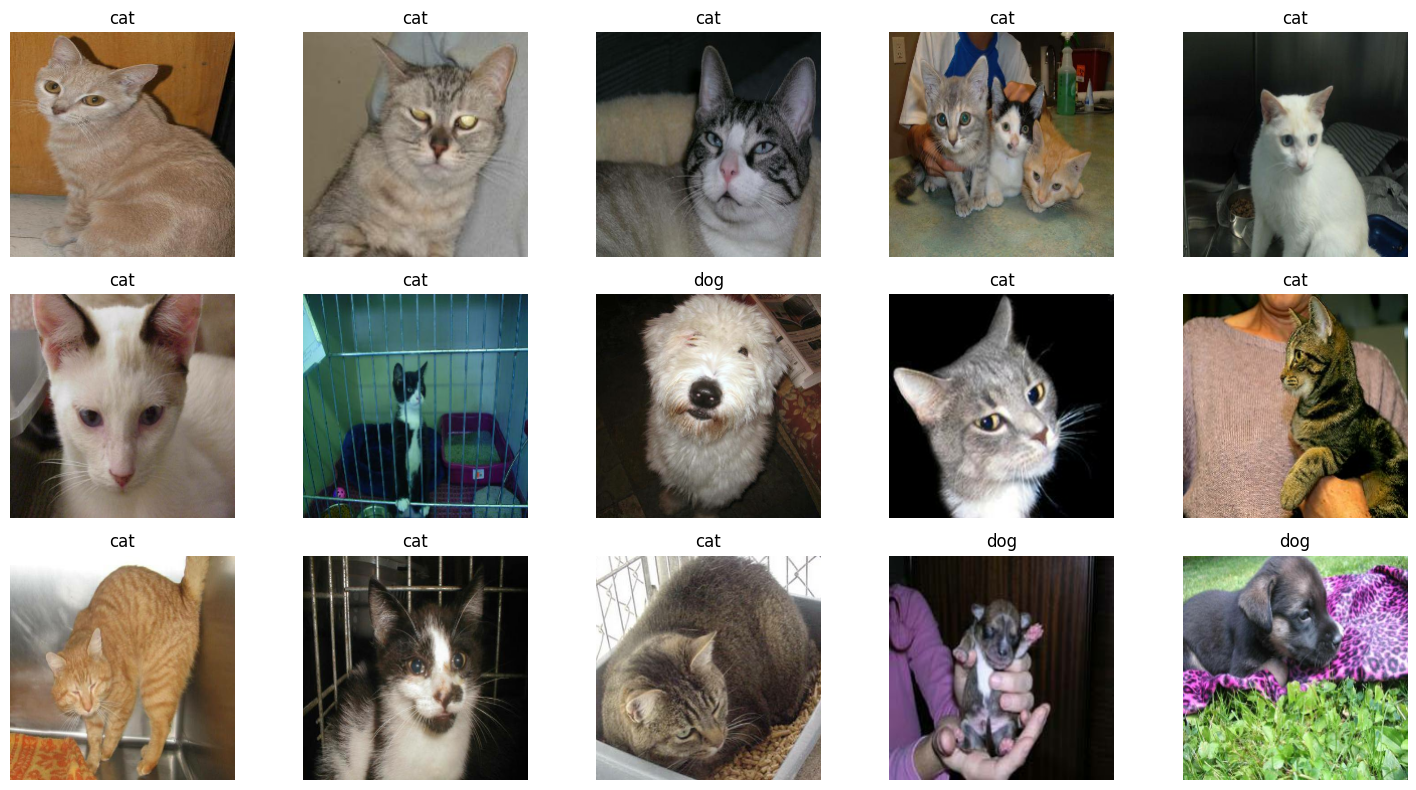

In [6]:
import matplotlib.pyplot as plt

def visualize_samples(dataset, label_encoder, num_samples=10):

    # Get a batch of images and labels
    for images, labels in dataset.take(1):
        images = images.numpy()
        labels = labels.numpy()
    
    # Decode integer labels to original class names
    class_names = label_encoder.inverse_transform(labels)
    
    # Setup plot dimensions
    plt.figure(figsize=(15, 8))
    num_cols = 5
    num_rows = int(np.ceil(num_samples / num_cols))
    
    for i in range(num_samples):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(images[i])
        plt.title(class_names[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage example
visualize_samples(train_dataset, label_encoder, num_samples=15)


In [7]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42
)


In [8]:
from tensorflow.keras.applications import MobileNetV3Large, MobileNetV3Small


def create_mobilenetv3_model(input_shape, num_classes, model_type='large'):
    # Load the MobileNetV3 model with pre-trained weights from ImageNet
    if model_type == 'large':
        base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=input_shape, include_preprocessing=False)
    elif model_type == 'small':
        base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=input_shape, include_preprocessing=False)
    else:
        raise ValueError("model_type must be 'large' or 'small'")

    # Freeze the base_model
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)  # Use GlobalAveragePooling2D instead of Flatten for efficiency

    # Add Dense layers with L2 regularization
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model


In [13]:
from tensorflow.keras.optimizers import Adam

# Convert image_paths and labels to NumPy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Single train-validation split instead of cross-validation
X_train, X_val, y_train, y_val = train_test_split(
    image_paths,
    labels,
    test_size=0.2,  # 20% validation split
    stratify=labels,  # Maintain class distribution
    random_state=42
)

input_shape = (224, 224, 3)  # Your image dimensions

# Define callbacks
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
)

# Create TensorFlow datasets
train_dataset = make_dataset(X_train, y_train, batch_size=batch_size, shuffle=True)
val_dataset = make_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)

# Create and compile model
model = create_mobilenetv3_model(input_shape, 2)

# Set learning rate to 0.001 in the optimizer
optimizer = Adam(learning_rate=0.001)  # Fixed learning rate

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping],  # Only early stopping callback
    verbose=1
)

# Save history after training
np.save('training_history.npy', history.history)

# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
print(f"Final Validation Loss = {val_loss:.4f}, Validation Accuracy = {val_accuracy:.4f}")

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 349s 539ms/step - accuracy: 0.9575 - loss: 0.9888 - val_accuracy: 0.9834 - val_loss: 0.5104
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 313s 500ms/step - accuracy: 0.9776 - loss: 0.4549 - val_accuracy: 0.9852 - val_loss: 0.2721
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 275s 440ms/step - accuracy: 0.9803 - loss: 0.2562 - val_accuracy: 0.9844 - val_loss: 0.1816
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 424ms/step - accuracy: 0.9815 - loss: 0.1843 - val_accuracy: 0.9832 - val_loss: 0.1593
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 423ms/step - accuracy: 0.9801 - loss: 0.1627 - val_accuracy: 0.9830 - val_loss: 0.1462
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 265s 425ms/step - accuracy: 0.9804 - loss: 0.1560 - val_accuracy: 0.9854 - val_loss: 0.1378
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 485ms/step - accuracy: 0.9784 - loss: 0.1546 - val_accuracy: 0.9840 - val_loss: 0.1416
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 336s 537ms/step - accuracy: 0.9801 -

In [26]:
for images, labels in val_dataset.take(1):
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    print("True labels:", labels)
    print("Predicted labels:", predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
True labels: tf.Tensor([1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0], shape=(32,), dtype=int64)
Predicted labels: [1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 1 0 0 0 0]


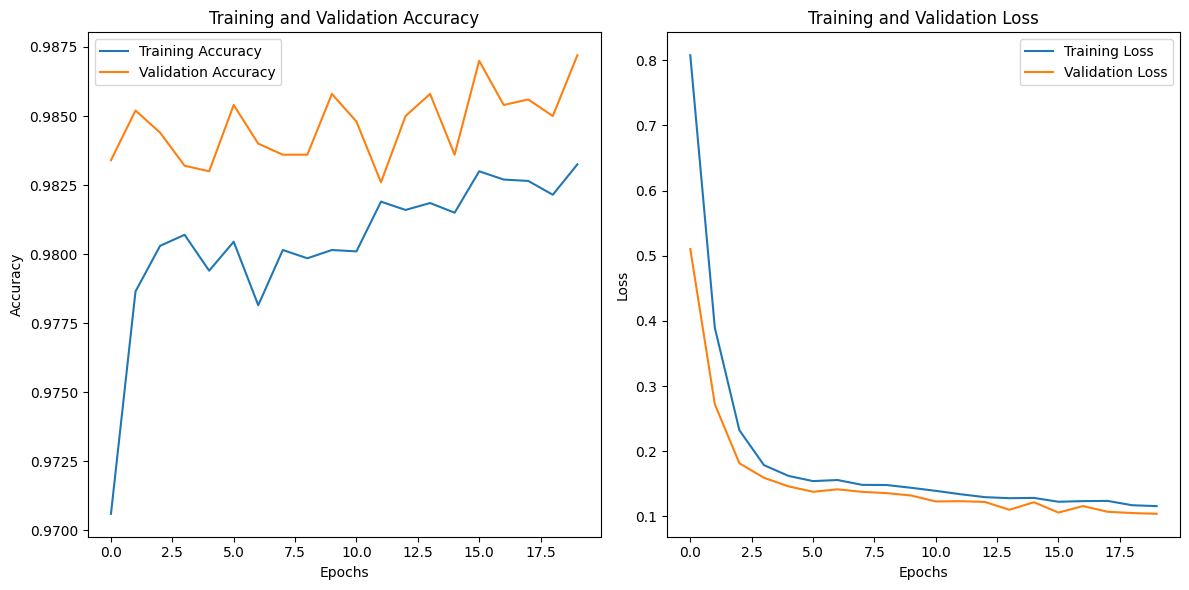

In [29]:
def plot_training_history(history):
    """
    Plot training and validation accuracy and loss.

    Args:
        history: Keras history object returned by model.fit().
    """
    plt.figure(figsize=(12, 6))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    
plot_training_history(history)